# General linear model

* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
        * [Define functions](#sub_section_1_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
    * [Signal quality metrics and channel rejection](#section_1_3)
        * [Visual inspection](#sub_section_1_3_1)
        * [Scalp-coupling index](#sub_section_1_3_2)
        * [Peak spectral power](#sub_section_1_3_3)
    * [Motion artefact correction](#section_1_4)
* [Post-processing](#chapter_2)
    * [Canonical model](#section_2_1) 
        * [Create design matrix](#sub_section_2_1_1)
        * [Fit GLM to data](#sub_section_2_1_2)
        * [Analyze region of interest](#sub_section_2_1_3)
        * [Compute contrast](#sub_section_2_1_4)
    * [Deconvolution (or FIR) model](#section_2_2) 
        * [Create design matrix](#sub_section_2_2_1)
        * [Fit GLM to data](#sub_section_2_2_2)
        * [Analyze region of interest](#sub_section_2_2_3)
        * [Compute contrast](#sub_section_2_2_4)

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [1]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_nirs
import pywt
import scipy
import dabest
import pylab
import pathlib
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info, source_detector_distances
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression
from mne_nirs.experimental_design import make_first_level_design_matrix, longest_inter_annotation_interval
from mne_nirs.statistics import run_glm
from mne.preprocessing import ICA, corrmap
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr, probplot, kstest, ttest_ind, ttest_rel, t
from scipy.signal import wiener, lfilter
from scipy.interpolate import CubicSpline
from scipy.linalg import hankel
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from nilearn.plotting import plot_design_matrix
from nilearn.glm import first_level
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.robust.norms import TukeyBiweight

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_21656\2729847526.py:27: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Write own fucntions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def add_info2(raw_intensity, first_name, last_name, age, sex, EHI):
    """
    Input: raw object, first name, last name, age, sex, EHI
    Function: Returns raw object with added subject info
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    return raw

def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        %matplotlib inline
        gyro_data.plot(title='Gyroscope data', grid = True, xlabel = 'samples', ylabel = 'dps')
        acc_data.plot(title='Accelerometer data', grid = True, xlabel = 'samples', ylabel = 'm/s^2')
        plt.show()

    return IMU_data, acc_data, gyro_data

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = True
# Export figures?
export = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [4]:
raws2 = []
data_dir = pathlib.Path("C:/Users/fabia/fNIRS data analysis/FTT analysis/FTT2/FTT2 data_BIDS")
bids_root = data_dir.with_name(data_dir.name)
for sub in range(1, 5):  # Loop from first to fourth subject
    # Create path to file based on experiment info
    bids_path = BIDSPath(subject="%02d" % sub, task="grasping", datatype="nirs",
                         root=bids_root, suffix="nirs",
                         extension=".snirf")
    raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
raws2

C:\Users\fabia\AppData\Local\Temp\ipykernel_21656\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_21656\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_21656\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))
C:\Users\fabia\AppData\Local\Temp\ipykernel_21656\937361362.py:9: RuntimeWarning: Unable to map "sex" value "None" to MNE. Not setting subject sex.
  raws2.append(read_raw_bids(bids_path=bids_path, verbose=False))


[<RawSNIRF | sub-01_task-grasping_nirs.snirf, 52 x 6160 (1188.7 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-02_task-grasping_nirs.snirf, 52 x 5900 (1014.6 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-03_task-grasping_nirs.snirf, 52 x 6389 (1149.8 s), ~52 kB, data not loaded>,
 <RawSNIRF | sub-04_task-grasping_nirs.snirf, 52 x 6282 (1136.9 s), ~52 kB, data not loaded>]

In [5]:
raw_intensities = []
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
for sub in range(4):
    raw_intensities.append(reorder(raws2[sub]))

#### Add info to raw intensity data <a class="anchor" id="sub_section_1_2_2"></a>

In [6]:
raw_intensities[0] = add_info2(raw_intensities[0], 'Subject', '1', 22, 'male', 'right')
raw_intensities[1] = add_info2(raw_intensities[1], 'Subject', '2', 61, 'female', 'right')
raw_intensities[2] = add_info2(raw_intensities[2], 'Subject', '3', 64, 'male', 'right')
raw_intensities[3] = add_info2(raw_intensities[3], 'Subject', '4', 26, 'male', 'right')

In [7]:
# Look at characteristics
sfreqs = []
lowpass = []
for sub in range(4):
    sfreqs.append(raw_intensities[sub].info['sfreq'])
    lowpass.append(raw_intensities[sub].info['lowpass'])
print('Sample frequencies (Hz): ' + str(sfreqs))
print('Max bandwidth (Hz): ' + str(lowpass))

Sample frequencies (Hz): [5.181347150259067, 5.813953488372094, 5.555555555555555, 5.524861878453039]
Max bandwidth (Hz): [2.5906735751295336, 2.906976744186047, 2.7777777777777777, 2.7624309392265194]


In [8]:
# Look at segments
events = []
event_dicts = []
for sub in range(4):
    event, event_dict = mne.events_from_annotations(raw_intensities[sub])
    events.append(event)
    event_dicts.append(event_dict)
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 21))

mne.viz.plot_events(events[0], event_id=event_dicts[0], sfreq=raw_intensities[0].info['sfreq'], axes=axes[0,0], show = False)
mne.viz.plot_events(events[1], event_id=event_dicts[1], sfreq=raw_intensities[1].info['sfreq'], axes=axes[0,1], show = False)
mne.viz.plot_events(events[2], event_id=event_dicts[2], sfreq=raw_intensities[2].info['sfreq'], axes=axes[1,0], show = False)
mne.viz.plot_events(events[3], event_id=event_dicts[3], sfreq=raw_intensities[3].info['sfreq'], axes=axes[1,1], show = False)
axes[0,0].set_title('Participant 1', fontweight="bold")
axes[0,1].set_title('Participant 2', fontweight="bold")
axes[1,0].set_title('Participant 3', fontweight="bold")
axes[1,1].set_title('Participant 4', fontweight="bold")

fig.show()

Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']


---
> *Remark:*
- 26 channels * 2 wavelengths = 52 channels
- Different sample frequencies are used for each participant = [5.181347150259067, 5.813953488372094, 5.555555555555555, 5.524861878453039] Hz
- LPF = [2.5906735751295336, 2.906976744186047, 2.7777777777777777, 2.7624309392265194] Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
- 10 random selected control segments within the baseline recording period
- 10 left and 10 right hand grasping segments
---

##### Resample data

In [9]:
f_min = np.min(sfreqs)
for sub in range(4):
    raw_intensities[sub].resample(f_min)

Sampling frequency of the instance is already 5.181347150259067, returning unmodified.


---
> *Remark:*
- Sample frequencies are downsampled to lowest sample frequency of the 4 subjects
- Sample frequency: 5.18 Hz
- LPF = 2.59 Hz -  Related to max bandwidth (Nyquist theorem): $F_{max} = \frac{F_s}{2}$
---

##### Validate that the location of sources-detector pairs and channels are in the expected locations

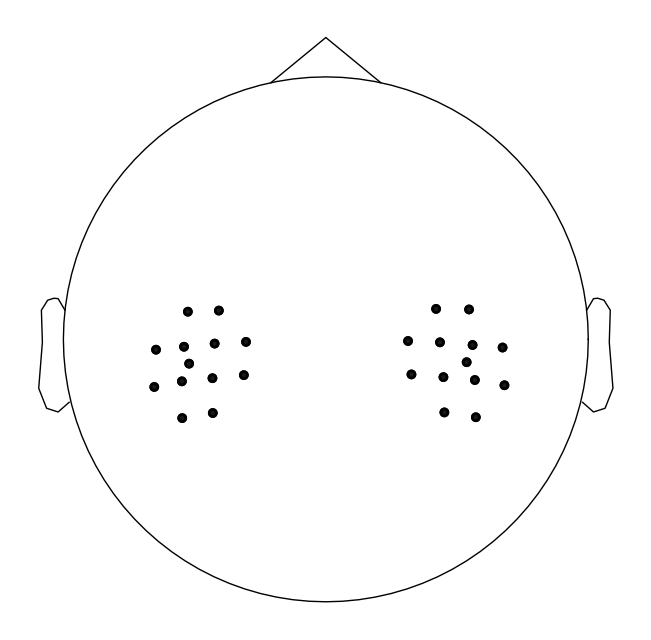

In [10]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensities[0].plot_sensors();

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

In [11]:
sns.set_theme()

### Signal quality metrics and channel rejection <a class="anchor" id="section_1_3"></a>

#### Visual inspection <a class="anchor" id="sub_section_1_3_1"></a>

The quality of a fNIRS recording can be assessed by a visual inspection of the signals. On the one hand there can be features present in the signals which indicate a good signal quality, such as certain physiological components, and on the other hand there can be features present which indicate bad signal quality in one or more channels, such as MAs.

##### Visual inspection of the raw light intensity data

###### Subject 1 

In [12]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[0].plot(duration=300, show_scrollbars = True, clipping = None);

Using matplotlib as 2D backend.


###### Subject 2

In [13]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[1].plot(duration=300, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


###### Subject 3

In [14]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[2].plot(duration=300, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


###### Subject 4

In [15]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensities[3].plot(duration=300, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [16]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_ods = []
for sub in range(4):
    raw_ods.append(optical_density(raw_intensities[sub]))

Reading 0 ... 6159  =      0.000 ...  1188.687 secs...


###### Subject 1

In [17]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[0].plot(duration=300, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


###### Subject 2

In [18]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[1].plot(duration=300, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


###### Subject 3

In [19]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[2].plot(duration=300, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


###### Subject 4

In [20]:
# Plot OD
if plot:
    %matplotlib qt
    raw_ods[3].plot(duration=300, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


---
> *Remark:*
- For more information about the visual inspection procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

##### Separate long and short channels

The short channels were not assessed using signal quality metrics because they inherently contain physiological noise. These channels cannot be removed from the dataset as they are essential for performing short channel regression.


In [21]:
raw_ods_full = []
raw_ods_short = []
raw_ods_new = []
min_dist = 0.01 
max_dist = 0.045
for sub in range(4):
    raw_ods_full.append(raw_ods[sub].copy())
    raw_ods_short.append(get_short_channels(raw_ods[sub], max_dist=min_dist))
    raw_ods_new.append(get_long_channels(raw_ods[sub], min_dist=min_dist, max_dist=max_dist))

In [22]:
raw_ods = raw_ods_new

In [23]:
# Short channels are: (channel number 16 and 17)
raw_ods_full[0].ch_names[32:36]

['S9_D1 760', 'S9_D1 850', 'S10_D2 760', 'S10_D2 850']

#### Scalp-coupling index <a class="anchor" id="sub_section_1_3_2"></a>

The SCI is a quality measurement of the connection between the optodes and the scalp of the participant using the strong cardiac oscillation in raw fNIRS signals. With a sufficiently high sampling rate (e.g.: 10 Hz), the heartbeat emerges as a dependable marker for evaluating optode-scalp coupling. It was first introduced by Pollonini et al. (2013) and it assesses the synchronous cardiac pulsation in the two photodetected signals (760 and 850 nm) in the cardiac band (0.5 - 2.5 Hz). After the bandpass-filtering the resulting signals are normalized to balance any difference between their amplitude. Finally, the zero-lag cross-correlation between photodetected signals of the same channel is used as a quantitative measure of the SNR of that specific channel. A threshold of SCI $>$ 0.75 is recommended by the authors.

Given that the frequency band of 0.5 - 2.5 Hz is quite broad and the participants are relatively at rest while seated, a FIR filter with a narrower band of 0.7 - 1.5 Hz is applied (40 bpm - 85 bpm). The transition band width at both the low and high cut-off frequencies is set to 0.3 Hz.

##### SCI evaluated over complete signal

In [24]:
# Calculate SCI with build-in function of mne_nirs
scis = []
for sub in range(4):
    scis.append(scalp_coupling_index(raw_ods[sub], l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False))
    # SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

In [25]:
# Copy raw object to apply SCI 
raw_od_SCIs = []
for sub in range(4):
    raw_od_SCIs.append(raw_ods[sub].copy())
# Mark channels with SCI < 0.75 as BAD
for sub in range(4):
    raw_od_SCIs[sub].info['bads'] = list(compress(raw_ods[sub].ch_names, scis[sub] < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
    print('The ' + str(len(raw_od_SCIs[sub].info['bads'])) + ' bad channels for subject ' + str(sub+1) + ' are: ' + str(raw_od_SCIs[sub].info['bads']))

The 14 bad channels for subject 1 are: ['S3_D1 760', 'S3_D1 850', 'S7_D1 760', 'S7_D1 850', 'S6_D4 760', 'S6_D4 850', 'S7_D3 760', 'S7_D3 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S7_D9 760', 'S7_D9 850']
The 16 bad channels for subject 2 are: ['S2_D2 760', 'S2_D2 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S2_D8 760', 'S2_D8 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']
The 0 bad channels for subject 3 are: []
The 20 bad channels for subject 4 are: ['S1_D1 760', 'S1_D1 850', 'S3_D1 760', 'S3_D1 850', 'S5_D1 760', 'S5_D1 850', 'S7_D1 760', 'S7_D1 850', 'S8_D2 760', 'S8_D2 850', 'S8_D4 760', 'S8_D4 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']


##### SCI evaluated over moving window

Some extra channels are marked bad due to consistent bad scores over time (see **Signal quality metrics and channel rejection - FTT 2** Notebook).

In [26]:
# Add bad channels
raw_od_SCIs[2].info['bads'] += ['S6_D6 760', 'S6_D6 850']
raw_od_SCIs[3].info['bads'] += ['S2_D2 760', 'S2_D2 850']

---
> *Remark:*
- For more information about the scalp-oupling index procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

#### Peak spectral power <a class="anchor" id="sub_section_1_3_3"></a>

Pollonini et al. (2016) state that to enhance the reliability of a quantitative measure for scalp coupling, the spectral power of the cross-correlated signal can serve as an additional indicator of cardiac signal strength. By setting a spectral power threshold, it becomes possible to objectively differentiate between a clear optical channel and a noisy one. Theoretically, photodetected cardiac signals can be conceptualized as two sinusoidal waves oscillating at the physiological frequency $f_{cardiac}$ (e.g.: 1 Hz or 60 bpm) with arbitrary amplitude and offset. The resultant normalized cross-correlation signal ($\overline{x_{\lambda_1}}  \otimes \overline{x_{\lambda_2}}$) exhibits unity amplitude, a frequency of $f_{cardiac}$ and a peak power of 0.5. Therefore, a threshold can be established at a certain fraction of the ideal peak power. However, in practice, cardiac photoplethysmographic signals are not strictly sinusoidal and may contain quantization noise, which reduces the peak power value. Hence, the authors recommend empirically setting the threshold value at 0.1.

In [27]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_od_SCI_PSPs = []
for sub in range(4):
    raw_od_SCI_PSP, scores, times = peak_power(raw_od_SCIs[sub], time_window=10)
    raw_od_SCI_PSPs.append(raw_od_SCI_PSP)

---
> *Remark:*
- For more information about the peak spectral power procedure can be found in the **Signal quality metrics and channel rejection - FTT 2** Notebook.
---

---
> *Remark:*
- Some time segments are marked manually as bad
- Selection of channels marked as bad through SCI
- Peak spectral power marked time segments in selected channels bad
---

### Motion artefact correction <a class="anchor" id="section_1_4"></a>

#### Temporal derivative distribution repair <a class="anchor" id="sub_section_1_4_1">

The TDDR method was introduced by Fishburn et al. in 2019. It offers both online and offline filtering approaches based on the temporal derivative of fNIRS signals, requiring no user-defined parameters. Moreover, it is applicable to concentration changes, optical intensities, and optical densities (Huang et al., 2022).

This method operates under specific assumptions: (1) non-motion-related fluctuations follow a normal distribution, (2) the majority of fluctuations are unrelated to motion artifacts, and (3) MA derivatives dominate in the derivatives of fNIRS signals during their presence.

The algorithm comprises five distinct steps. Fishburn et al. (2019) provides an in-depth description of each step.

##### Perform TDDR on OD data

In [28]:
# Add short channels again
for sub in range(4):
    raw_od_SCIs[sub].add_channels([raw_ods_short[sub]])

In [29]:
raw_ods_TDDR = []
for sub in range(4):
    raw_ods_TDDR.append(temporal_derivative_distribution_repair(raw_od_SCIs[sub]))

---
> *Remark:*
- By incorporating signals from auxiliary measurements of systemic physiology (e.g.: short-separation measurements, BP, cardiac oscillations, respiration) or head motion (e.g.: accelerometers) the GLM can simultaneously extract the HRF while also filtering out confounding signals using regressors, instead of filtering and correcting confounding signals before estimating the HRF and performing block averaging (Von Luhmann et al., 2020).
- As a result, no short channel regression or bandpass-filtering is performed on the data
---

##### Convert OD data to haemodynamic data

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [30]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
raw_haemos_short = []
raw_haemos = []
for sub in range(4):
    raw_haemo = beer_lambert_law(raw_ods_TDDR[sub], ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.
    raw_haemos_short.append(get_short_channels(raw_haemo, max_dist=min_dist)) 
    raw_haemos.append(get_long_channels(raw_haemo, min_dist=min_dist, max_dist=max_dist))

Channels marked as bad:
none


## Post-processing <a class="anchor" id="chapter_2"></a>

### Canonical model <a class="anchor" id="section_2_1"></a>

#### Create design matrix <a class="anchor" id="sub_section_2_1_1"></a>

##### Select drift model
Aspects of the measured signal may change over time in a manner unrelated to the neural response.

Two types of regressors are provided for in MNE-NIRS thanks to Nilearn:
1. Polynomial: With increasing polynomial order, higher frequency components will be regressed from the signal.
2. Cosine: Regressors can be specified up to a certain frequency (HPF).

In [53]:
drift_model='cosine'

##### Define high-pass frequency in case of a cosine model

The cutoff period (1/high_pass) should be set as the longest period between two trials of the same condition multiplied by 2.

In [68]:
high_pass = []
for sub in range(4):
    high_pass.append(1/(2*max(longest_inter_annotation_interval(raw_haemos[sub])[0])))
print(str(high_pass) + ' Hz')

[0.0022275783105155066, 0.004977699904428163, 0.0035842293906810036, 0.00477929228239882] Hz


In [75]:
# Or use predefined function
# mne_nirs.experimental_design.drift_high_pass(raw_haemo)

##### Select HRF model

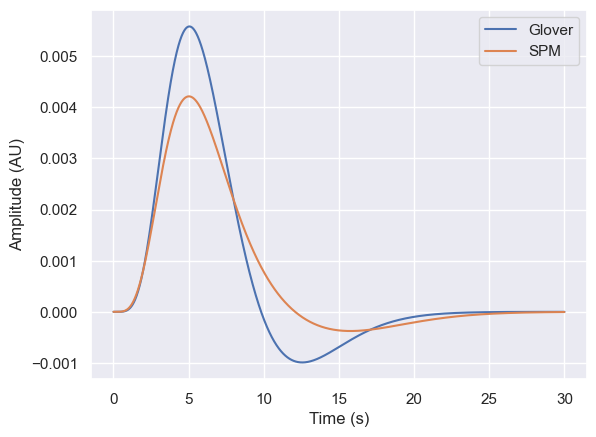

In [59]:
time_length = 30

glover_timecourse = first_level.glover_hrf(1, oversampling=50, time_length=time_length)
spm_timecourse = first_level.spm_hrf(1, oversampling=50, time_length=time_length)

sample_times = np.linspace(0, time_length, num=len(glover_timecourse))

%matplotlib inline
plt.plot(sample_times, glover_timecourse, label="Glover")
plt.plot(sample_times, spm_timecourse, label="SPM")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (AU)")
plt.legend()

In [60]:
# Choose HRF model
hrf_model = 'spm'

##### Evaluate shape of HRF for task duration

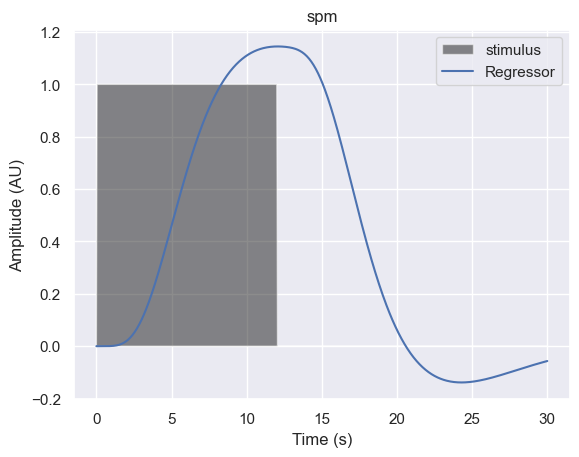

In [62]:
# Functions from MNE_NIRS tutorial
def generate_stim(onset, amplitude, duration, hrf_model, maxtime=30):

    # Generate signal with specified duration and onset
    frame_times = np.linspace(0, maxtime, 601)
    exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)
    stim = np.zeros_like(frame_times)
    stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude

    signal, name = first_level.compute_regressor(
        exp_condition, hrf_model, frame_times, con_id="main", oversampling=16
    )

    return frame_times, stim, signal


def plot_regressor(onset, amplitude, duration, hrf_model):
    frame_times, stim, signal = generate_stim(
        onset, amplitude, duration, hrf_model)
    plt.fill(frame_times, stim, "k", alpha=0.5, label="stimulus")
    plt.plot(frame_times, signal.T[0], label="Regressor")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (AU)")
    plt.legend(loc=1)
    plt.title(hrf_model)
    return None


# Generate an event to see shape HRF
onset, amplitude, duration = 0.0, 1.0, 12
plot_regressor(onset, amplitude, duration, hrf_model)

##### Define design matrix

Normalize raw_haemo first if IMU is used as regressor.

Z-score: 
$$x' = \frac{x - \mu}{\sigma}$$

In [63]:
norm = True

In [76]:
raw_haemos_org = []
if norm:
    for sub in range(4):
        mean_raw_haemo = np.mean(raw_haemos[sub].get_data(), axis = 1, keepdims=True)
        std_raw_haemo = np.std(raw_haemos[sub].get_data(), axis = 1, keepdims=True)
        raw_haemo_data_z_norm = (raw_haemos[sub].get_data() - mean_raw_haemo)/std_raw_haemo
        raw_haemos_org.append(raw_haemos[sub].copy())
        raw_haemos[sub]._data = raw_haemo_data_z_norm

In [77]:
# Check if data is normalized
print('mean: ' + str(np.abs(np.mean(raw_haemos[0].get_data(), axis = 1)) < 0.001 ))
print('std: ' + str(np.std(raw_haemos[0].get_data(), axis = 1)))

mean: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [80]:
design_matrices = []
for sub in range(4):
    design_matrices.append(make_first_level_design_matrix(raw_haemos[sub],
                                               drift_model = drift_model, # Options: ‘cosine’, ‘polynomial’
                                               # drift_order = 1, # Only for polynomial drift model
                                               high_pass = high_pass[sub], # Only in case cosine drift model
                                               hrf_model = hrf_model, # Options: ‘glover’, ‘spm’, ‘spm + derivative’, ‘spm + derivative + dispersion’, ‘glover + derivative’, ‘glover + derivative + dispersion’, ‘fir’
                                               stim_dur = duration))

In [81]:
design_matrices[0].head(5)

,Baseline,practice/LEFT,practice/RIGHT,test/LEFT,test/RIGHT,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0.000,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018019,1.0
0.193,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018019,1.0
0.386,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018018,1.0
0.579,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018018,0.018018,0.018018,1.0
0.772,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018018,0.018018,0.018018,1.0


##### Add SS as regressors

Different short-channel approaches are possible to correct for systemic response (Luke et al., 2021):
1. Adding the mean of the short channels as a regressor to the GLM
2. Adding the individual short channels as regressors to the GLM
3. Adding the principal components (PCs) of the short channels as regressors to the GLM (adding either a subset or all of the components)

In [85]:
def add_SS(raw_haemo_short, design_matrix, method = 'mean', n_components = 0.95, norm = True):
    design_matrix_ = design_matrix.copy()
    
    mean_raw_haemo_short = np.mean(raw_haemo_short.get_data(), axis = 1, keepdims=True)
    std_raw_haemo_short = np.std(raw_haemo_short.get_data(), axis = 1, keepdims=True)
    if norm:
        raw_haemo_short_data_z_norm = (raw_haemo_short.get_data() - mean_raw_haemo_short)/std_raw_haemo_short
        raw_haemo_short._data = raw_haemo_short_data_z_norm
    
    if method == 'mean':
        # Mean
        design_matrix_["ShortHbO"] = np.mean(raw_haemo_short.copy().pick(picks="hbo").get_data(), axis=0)
        design_matrix_["ShortHbR"] = np.mean(raw_haemo_short.copy().pick(picks="hbr").get_data(), axis=0)
    elif method == 'PCA':
        # PCs
        PCA_data = raw_haemo_short.copy().get_data().T
        # removing the mean and scaling to unit variance
        PCA_data_scaled = StandardScaler().fit_transform(PCA_data)
        
        pca = PCA(n_components) # select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.
         
        # Fit and transform data
        pca_features = pca.fit_transform(PCA_data_scaled).T
        print(str(len(pca_features)) + ' SSC are kept of the original ' + str(PCA_data.shape[1]))
        
        # Add as regressors
        for i in range(len(pca_features)):
            string = "ShortPCA_" + str(i)
            design_matrix_[string] = pca_features[i]

    else:
        # Individual
        for i in range(raw_haemo_short.copy().pick(picks="hbr").get_data().shape[0]):
            str_hbo = "ShortHbO_" + str(i)
            str_hbr = "ShortHbR_" + str(i)
            design_matrix_[str_hbo] = raw_haemo_short.copy().pick(picks="hbo").get_data()[i]
            design_matrix_[str_hbr] = raw_haemo_short.copy().pick(picks="hbr").get_data()[i]
    return design_matrix_, mean_raw_haemo_short, std_raw_haemo_short

In [87]:
design_matrices_SS = []
for sub in range(4):
    design_matrices_SS.append(add_SS(raw_haemos_short[sub], design_matrices[sub], method = 'mean', n_components = 0.95, norm = norm)[0])
design_matrices_SS[0].head(5)

,Baseline,practice/LEFT,practice/RIGHT,test/LEFT,test/RIGHT,drift_1,drift_2,drift_3,drift_4,drift_5,constant,ShortHbO,ShortHbR
0.000,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018019,1.0,-1.373490,-0.700581
0.193,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018019,1.0,-1.930211,-1.306350
0.386,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018018,1.0,-0.438676,0.311355
0.579,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018018,0.018018,0.018018,1.0,-0.535047,0.223035
0.772,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018018,0.018018,0.018018,1.0,-0.968457,-0.431956


In [88]:
# Check if short channel data is normalized
print('mean: ' + str(np.abs(np.mean(raw_haemos_short[0].get_data(), axis = 1)) < 0.001))
print('std: ' + str(np.std(raw_haemos_short[0].get_data(), axis = 1)))

mean: [ True  True  True  True]
std: [1. 1. 1. 1.]


##### Add IMU data as regressor

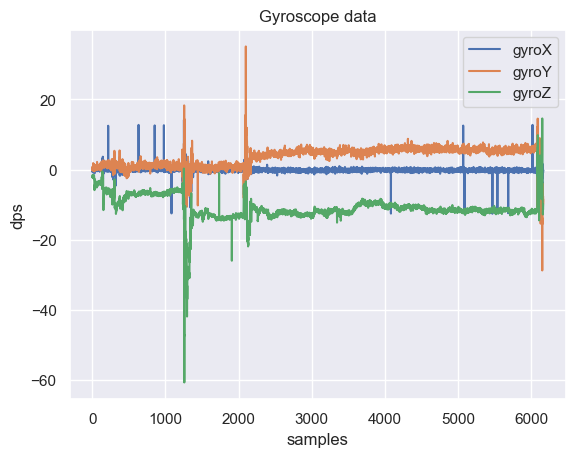

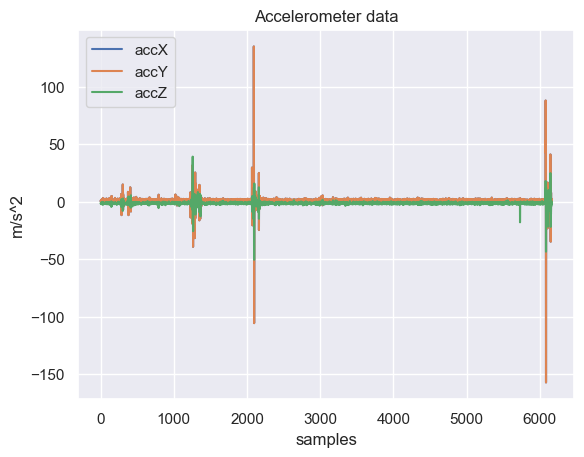

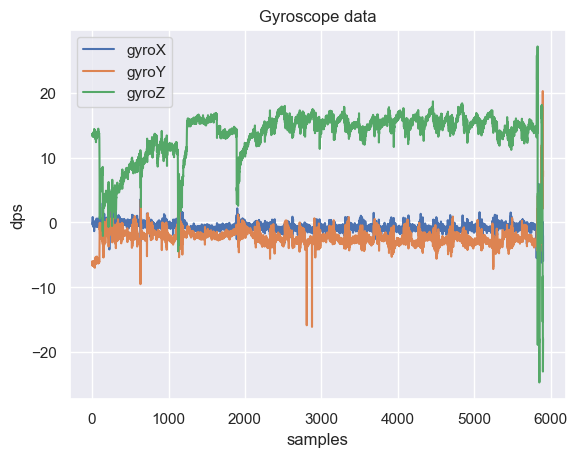

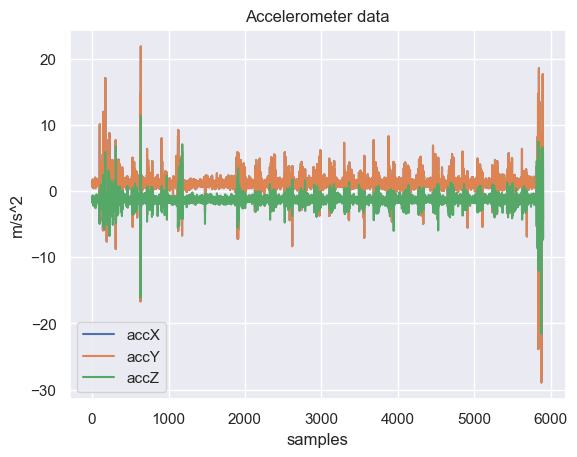

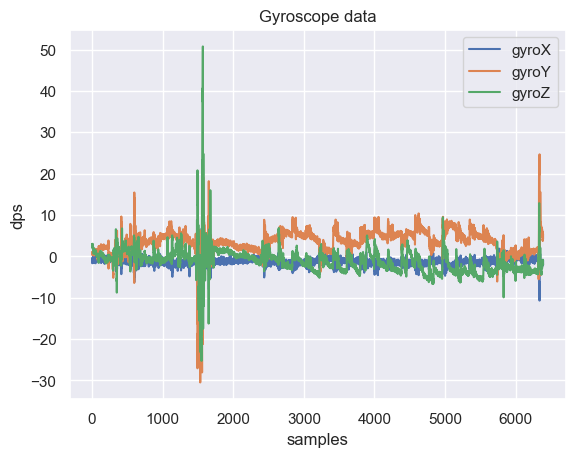

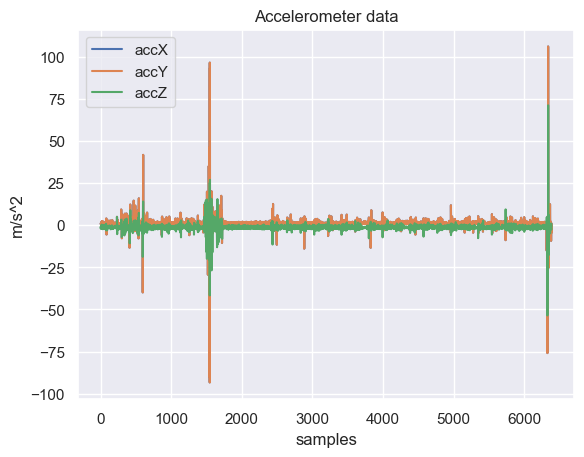

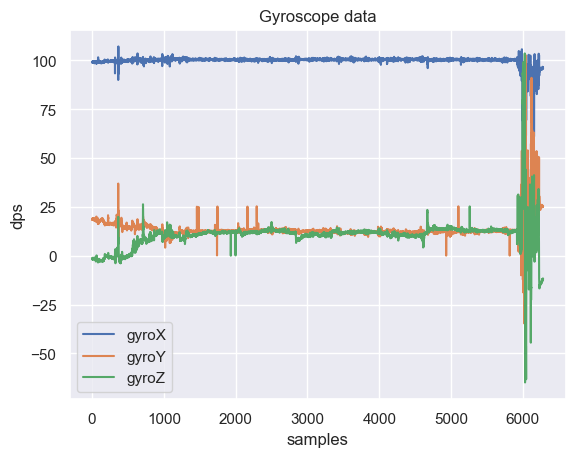

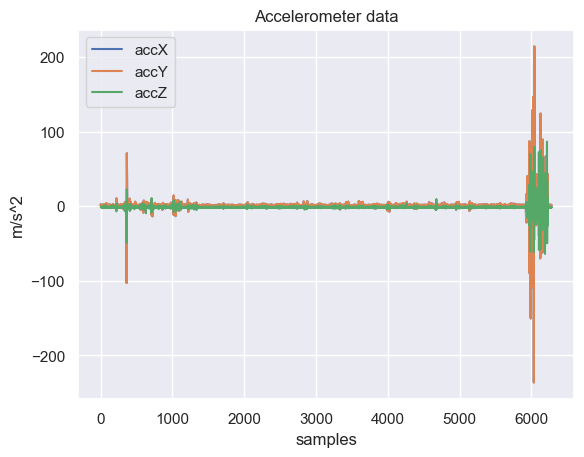

In [117]:
filenames_IMU = ['FTT2 IMU data/sub-0' + str(sub) + '_task-grasping_IMU.txt' for sub in range(1,5)]
IMU_datas_org = []
for filename in filenames_IMU:
    IMU_datas_org.append(get_IMU_data(filename, plot = True)[0])

In [119]:
# Resample IMU data (This is kind of a hack)
fs = raw_haemos[0].info['sfreq']
IMU_datas = [pd.DataFrame(), pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]
for sub in range(4):
    dummy = optical_density(raws2[sub]).copy()

    dummy._data[0] = IMU_datas_org[sub]['gyroX']
    dummy._data[1] = IMU_datas_org[sub]['gyroY']
    dummy._data[2] = IMU_datas_org[sub]['gyroZ']
    dummy._data[3] = IMU_datas_org[sub]['accX']
    dummy._data[4] = IMU_datas_org[sub]['accY']
    dummy._data[5] = IMU_datas_org[sub]['accZ']     
        
    if dummy.info['sfreq'] != fs:
        dummy.resample(fs)
    else:
        print('Subject ' + str(sub+1) + ' had already a sample frequency of ' + str(fs) + ' Hz')

    IMU_datas[sub]['gyroX'] = dummy.get_data()[0]
    IMU_datas[sub]['gyroY'] = dummy.get_data()[1]
    IMU_datas[sub]['gyroZ'] = dummy.get_data()[2]
    IMU_datas[sub]['accX'] = dummy.get_data()[3]
    IMU_datas[sub]['accY'] = dummy.get_data()[4]
    IMU_datas[sub]['accZ'] = dummy.get_data()[5]
    

Reading 0 ... 6159  =      0.000 ...  1188.687 secs...
Subject 1 had already a sample frequency of 5.181347150259067 Hz
Reading 0 ... 5899  =      0.000 ...  1014.628 secs...
Reading 0 ... 6388  =      0.000 ...  1149.840 secs...
Reading 0 ... 6281  =      0.000 ...  1136.861 secs...


In [120]:
def add_IMU(design_matrix, IMU_data, method = 'mean', n_components = 0.95, norm = True):
    design_matrix_ = design_matrix.copy()

    mean_IMU_data = IMU_data.mean(axis=0).to_numpy()
    std_IMU_data = IMU_data.std(axis=0).to_numpy()
    if norm:
        IMU_data_z_norm = (IMU_data.to_numpy() - mean_IMU_data)/std_IMU_data
        IMU_data = pd.DataFrame(data=IMU_data_z_norm, columns=IMU_data.columns)
    print('mean: ' + str(np.abs(IMU_data.mean(axis=0).to_numpy()) < 0.001))
    print('std: ' + str(IMU_data.std(axis=0).to_numpy()))
    if method == 'mean':
        # Mean
        design_matrix_["Acc"] = IMU_data[['accX', 'accY', 'accZ']].mean(axis = 1).to_numpy()
        design_matrix_["Gyro"] = IMU_data[['gyroX', 'gyroY', 'gyroZ']].mean(axis = 1).to_numpy()
    elif method == 'PCA':
        # PCs
        PCA_data = IMU_data.to_numpy()
        # removing the mean and scaling to unit variance
        PCA_data_scaled = StandardScaler().fit_transform(PCA_data)
        
        pca = PCA(n_components) # select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.
         
        # Fit and transform data
        pca_features = pca.fit_transform(PCA_data_scaled).T
        print(str(len(pca_features)) + ' IMU channels are kept of the original ' + str(PCA_data.shape[1]))
        
        # Add as regressors
        for i in range(len(pca_features)):
            string = "IMU_PCA_" + str(i)
            design_matrix_[string] = pca_features[i]

    else:
        # Individual
        for column in IMU_data.columns:
            design_matrix_[str(column)] = IMU_data[column].to_numpy()
    return design_matrix_, mean_IMU_data, std_IMU_data

In [121]:
design_matrices_SS_IMU = []
for sub in range(4):
    design_matrices_SS_IMU.append(add_IMU(design_matrices_SS[sub], IMU_datas[sub], method = 'PCA', n_components = 0.95, norm = norm)[0])

mean: [ True  True  True  True  True  True]
std: [1. 1. 1. 1. 1. 1.]
5 IMU channels are kept of the original 6
mean: [ True  True  True  True  True  True]
std: [1. 1. 1. 1. 1. 1.]
5 IMU channels are kept of the original 6
mean: [ True  True  True  True  True  True]
std: [1. 1. 1. 1. 1. 1.]
5 IMU channels are kept of the original 6
mean: [ True  True  True  True  True  True]
std: [1. 1. 1. 1. 1. 1.]
5 IMU channels are kept of the original 6


In [122]:
design_matrices_SS_IMU[0]

,Baseline,practice/LEFT,practice/RIGHT,test/LEFT,test/RIGHT,drift_1,drift_2,drift_3,drift_4,drift_5,constant,ShortHbO,ShortHbR,IMU_PCA_0,IMU_PCA_1,IMU_PCA_2,IMU_PCA_3,IMU_PCA_4
0.000,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018019,1.0,-1.373490,-0.700581,-0.117563,2.129365,-1.290854,-0.615289,1.184090
0.193,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018019,1.0,-1.930211,-1.306350,-0.188772,2.386815,-1.324435,-0.621191,0.692942
0.386,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018019,0.018019,0.018018,1.0,-0.438676,0.311355,-0.008623,2.261928,-1.400571,-0.633682,0.733726
0.579,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018018,0.018018,0.018018,1.0,-0.535047,0.223035,-0.007458,2.373076,-0.941986,-0.261941,0.837219
0.772,0.0,0.0,0.0,0.0,0.0,0.018019,0.018019,0.018018,0.018018,0.018018,1.0,-0.968457,-0.431956,0.289575,2.473496,-1.199976,-0.346421,0.704749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187.915,0.0,0.0,0.0,0.0,0.0,-0.018019,0.018019,-0.018018,0.018018,-0.018018,1.0,-0.955950,0.021110,0.362029,1.203360,-3.396147,2.737854,-0.652463
1188.108,0.0,0.0,0.0,0.0,0.0,-0.018019,0.018019,-0.018018,0.018018,-0.018018,1.0,-1.307977,-0.686813,0.566983,1.418601,-3.394364,1.251356,-2.209978
1188.301,0.0,0.0,0.0,0.0,0.0,-0.018019,0.018019,-0.018019,0.018019,-0.018018,1.0,-2.072829,-1.513761,0.464221,0.883862,-3.130477,1.517608,-1.264010
1188.494,0.0,0.0,0.0,0.0,0.0,-0.018019,0.018019,-0.018019,0.018019,-0.018019,1.0,-0.657502,-0.097797,0.811249,1.456710,-3.519478,2.083362,-1.406819


##### Display a summary of the design matrix 

The first three columns represent the SPM HRF convolved with our stimulus event information. The next columns illustrate the drift and constant components. The last columns illustrate the short channel signals and IMU regressors.

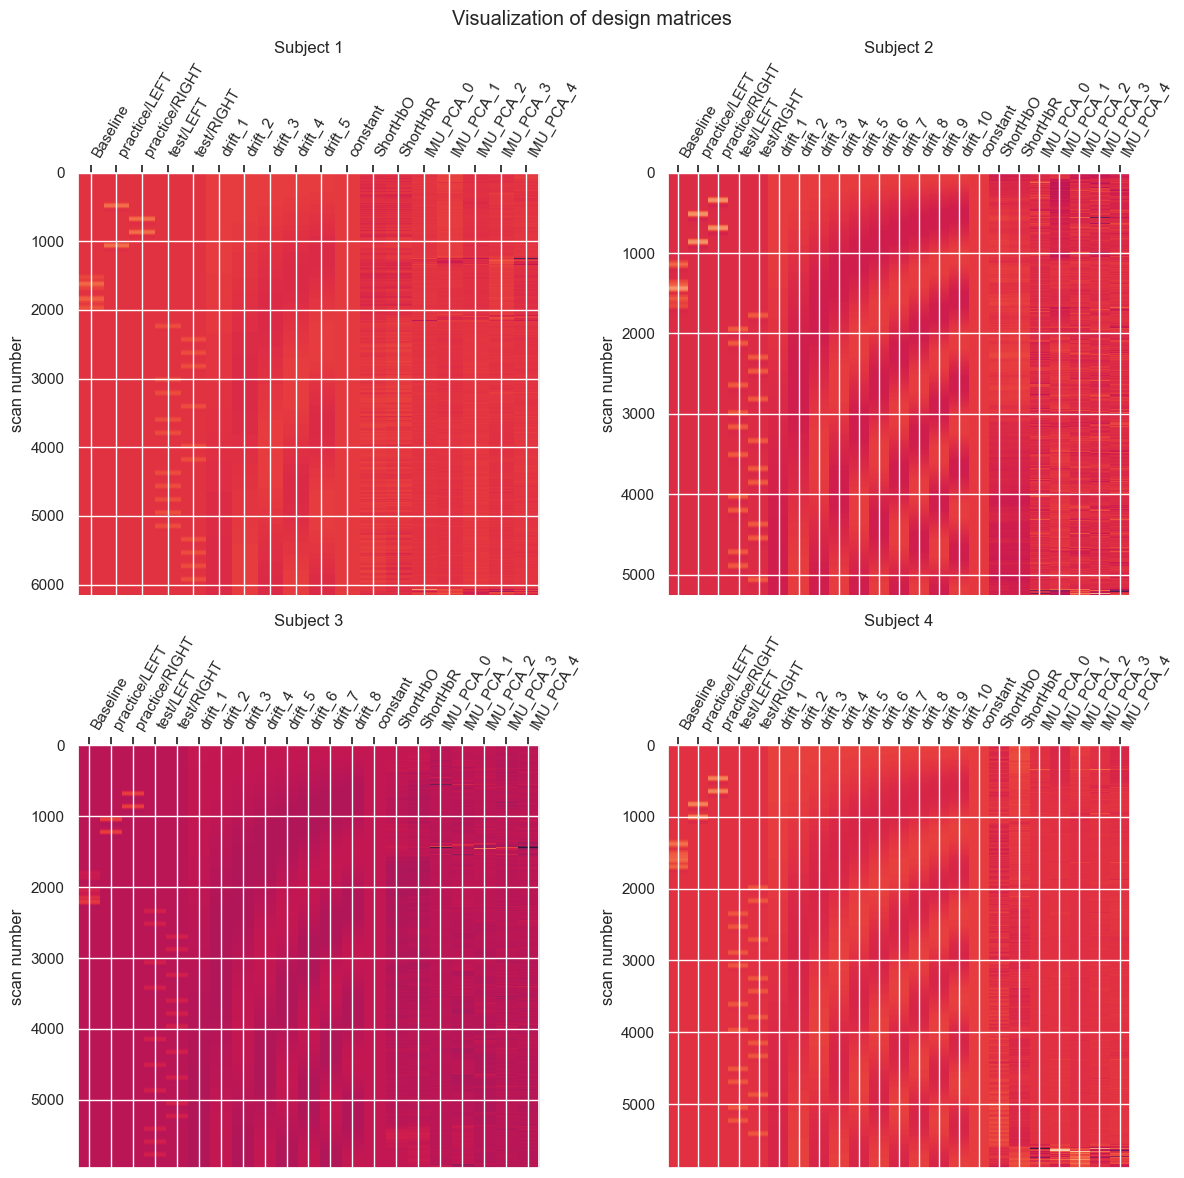

In [124]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Visualization of design matrices')
for sub, ax in enumerate([ax1, ax2, ax3, ax4]):
    plot_design_matrix(design_matrices_SS_IMU[sub], ax=ax);
    ax.set_title('Subject ' + str(sub+1))

---
> *Remark:*
- In the first three columns we can clearly see when the stimuli are present and that they induce a HRF function
- Different drift factors with different frequencies
---

##### Examine expected response

Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']
Used Annotations descriptions: ['Baseline', 'practice/LEFT', 'practice/RIGHT', 'test/LEFT', 'test/RIGHT']


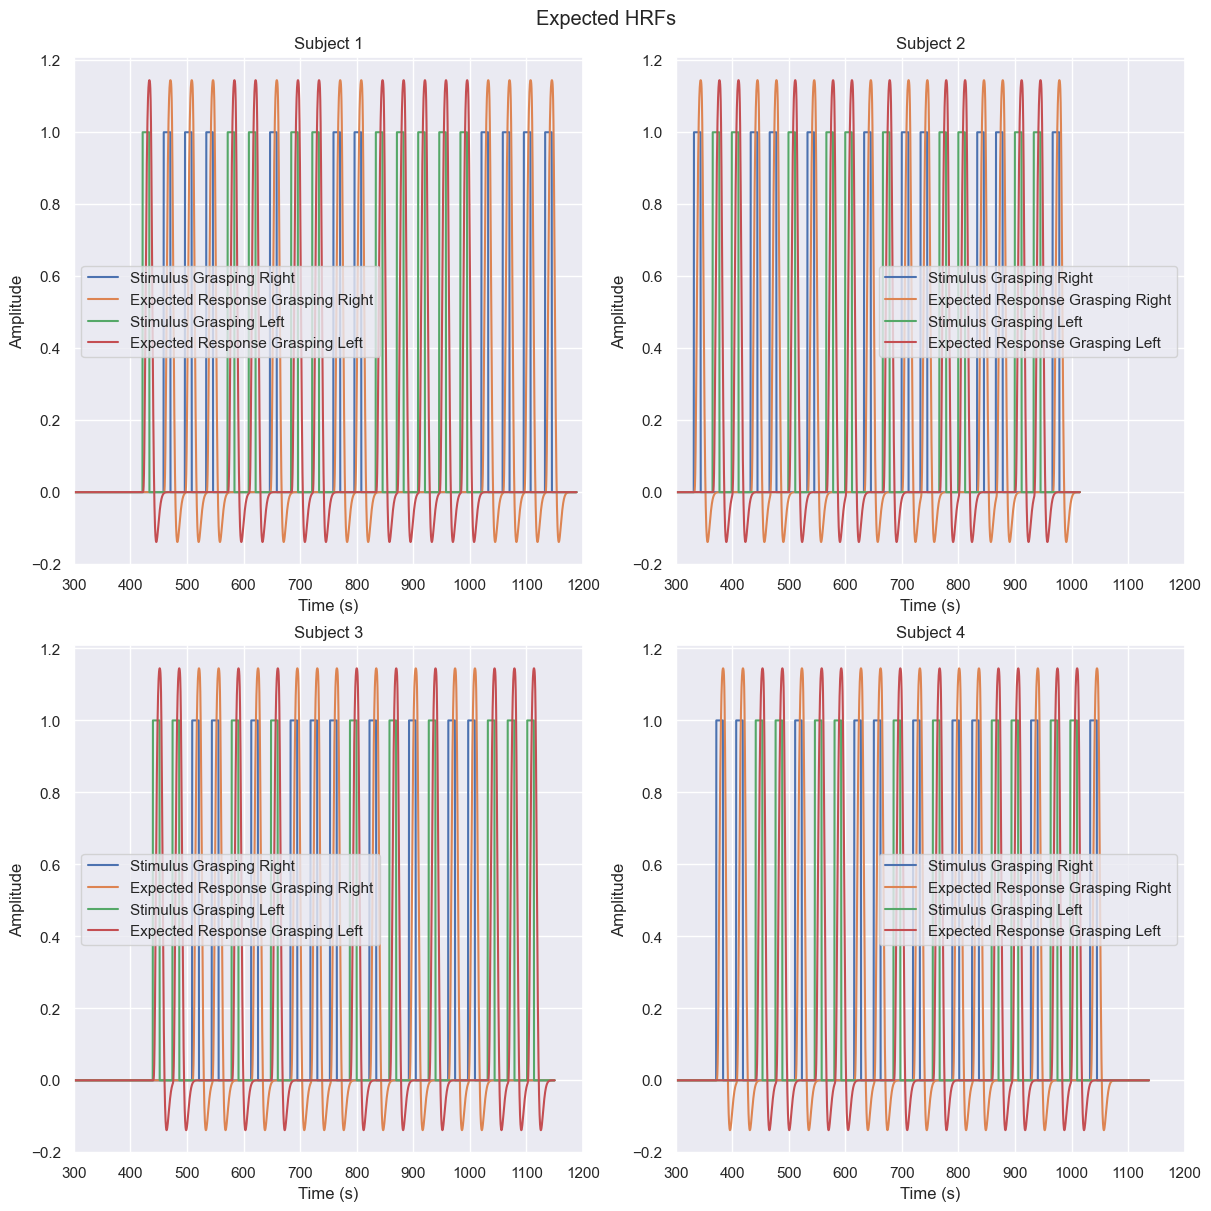

In [129]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (12,12), constrained_layout=True)
fig.suptitle('Expected HRFs')
for sub, ax in enumerate([ax1, ax2, ax3, ax4]):
    s = mne_nirs.experimental_design.create_boxcar(raw_haemos[sub], stim_dur=duration)
    ax.plot(raw_intensities[sub].times, s[:, 4])
    ax.plot(design_matrices_SS_IMU[sub]['test/RIGHT'])
    ax.plot(raw_intensities[sub].times, s[:, 3])
    ax.plot(design_matrices_SS_IMU[sub]['test/LEFT'])
    ax.legend(["Stimulus Grasping Right", "Expected Response Grasping Right", "Stimulus Grasping Left", "Expected Response Grasping Left"])
    ax.set(xlim=(300, 1200), xlabel="Time (s)", ylabel="Amplitude")
    ax.set_title('Subject ' + str(sub+1))

---
> *Remark:*
- abc
---

#### Fit GLM to data <a class="anchor" id="sub_section_2_1_2"></a>

##### Run a GLM fit for the data and experiment matrix

In [39]:
# AR model != AR-IRLS

In [40]:
glm_est = run_glm(raw_haemo, design_matrix_SS_IMU, noise_model='ar4') # {‘ar1’, ‘ols’, ‘arN’, ‘auto’}
glm_est

GLM Results for 48 channels

In [41]:
# Default auto regressive model order is 1
glm_est.data['S1_D1 hbo'].model.order

4

Text(0, 0.5, 'Delta Mol')

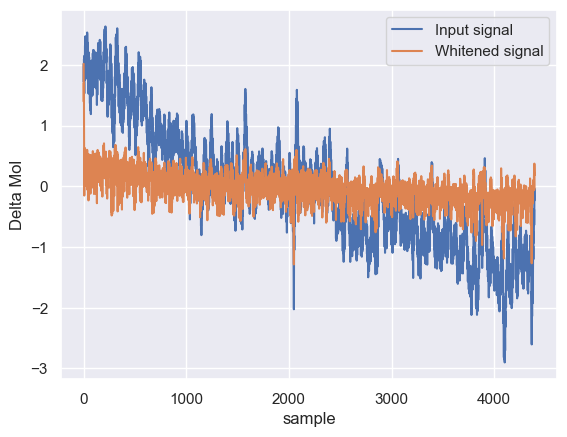

In [42]:
# Inspect whitened signal
plt.plot(glm_est.data['S6_D4 hbo'].Y)
plt.plot(glm_est.data['S6_D4 hbo'].whitened_Y)
plt.legend(["Input signal", "Whitened signal"])
plt.xlabel("sample")
plt.ylabel("Delta Mol")

##### Determine the mean square error and statistical significance of the estimates

In [43]:
MSE = glm_est.MSE()

In [44]:
glm_est.to_dataframe().head(30)

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,Baseline,36.0,0.039341,8.583461e-01,0.015862,0.179764,0.002852,1,1,hbo,False,S1_D1 hbo
1,Grasping/Left,36.0,0.039341,9.363691e-01,0.019252,0.080394,0.001548,1,1,hbo,False,S1_D1 hbo
2,Grasping/Right,36.0,0.039341,5.878795e-02,0.019025,1.951694,0.037131,1,1,hbo,False,S1_D1 hbo
3,IMU_PCA_0,36.0,0.039341,2.349607e-02,0.003611,-2.365798,-0.008543,1,1,hbo,True,S1_D1 hbo
4,IMU_PCA_1,36.0,0.039341,4.615382e-01,0.006912,-0.744280,-0.005145,1,1,hbo,False,S1_D1 hbo
5,IMU_PCA_2,36.0,0.039341,2.997396e-04,0.005532,4.001989,0.022139,1,1,hbo,True,S1_D1 hbo
6,IMU_PCA_3,36.0,0.039341,6.943665e-02,0.005866,1.871379,0.010978,1,1,hbo,False,S1_D1 hbo
7,ShortHbO,36.0,0.039341,2.242968e-39,0.008992,66.930518,0.601864,1,1,hbo,True,S1_D1 hbo
8,ShortHbR,36.0,0.039341,6.218055e-19,0.012408,-17.184509,-0.213226,1,1,hbo,True,S1_D1 hbo
9,constant,36.0,0.039341,4.664926e-01,0.006584,-0.736012,-0.004846,1,1,hbo,False,S1_D1 hbo


---
> *Remark:*
- abc
---

##### Display results of GLM in scatter plot

In [45]:
# Determine channels of left and right hemisphere
left = [[1, 1], [3, 1], [5, 1], [7, 1], [5, 3], [7, 3], [3, 5], [5, 5], [1, 7], [3, 7], [1, 9], [7, 9]]
right = [[2, 2], [4, 2], [6, 2], [8, 2], [6, 4], [8, 4], [4, 6], [6, 6], [2, 8], [4, 8], [2, 10], [8, 10]]
ROI_right = picks_pair_to_idx(raw_haemo.copy(), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy(), left, on_missing='warning')

<AxesSubplot: xlabel='Condition', ylabel='Theta'>

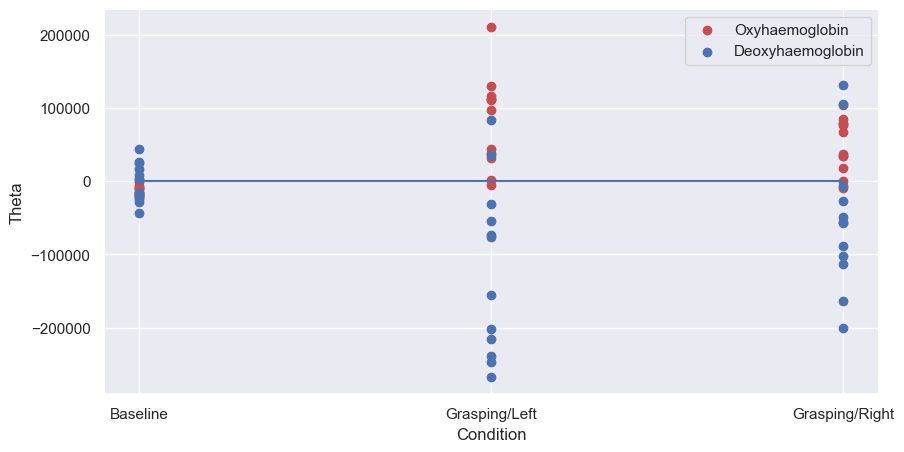

In [46]:
# Left hemisphere
glm_est.copy().pick(picks = ROI_left).scatter(conditions=['Baseline', 'Grasping/Left', 'Grasping/Right'])

<AxesSubplot: xlabel='Condition', ylabel='Theta'>

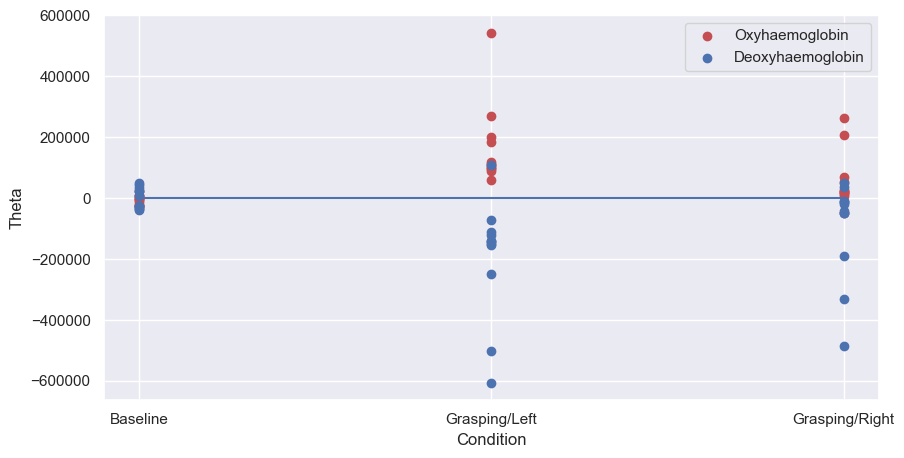

In [47]:
# Right hemisphere
glm_est.copy().pick(picks = ROI_right).scatter(conditions=['Baseline', 'Grasping/Left', 'Grasping/Right'])

---
> *Remark:*
-  Note that the control condition should sit around zero
-  HbO is positive and larger than the HbR
-  The response to tapping on the right hand is larger than the left hand, for the left hemisphere. And the opposite is true for the right hemisphere
-  big difference with and without SS
---

##### View the topographic distribution

This visual representation fits a smoothed surface to the data and makes many assumptions including that the data is spatially smooth and that the sensors sufficiently cover the scalp surface.

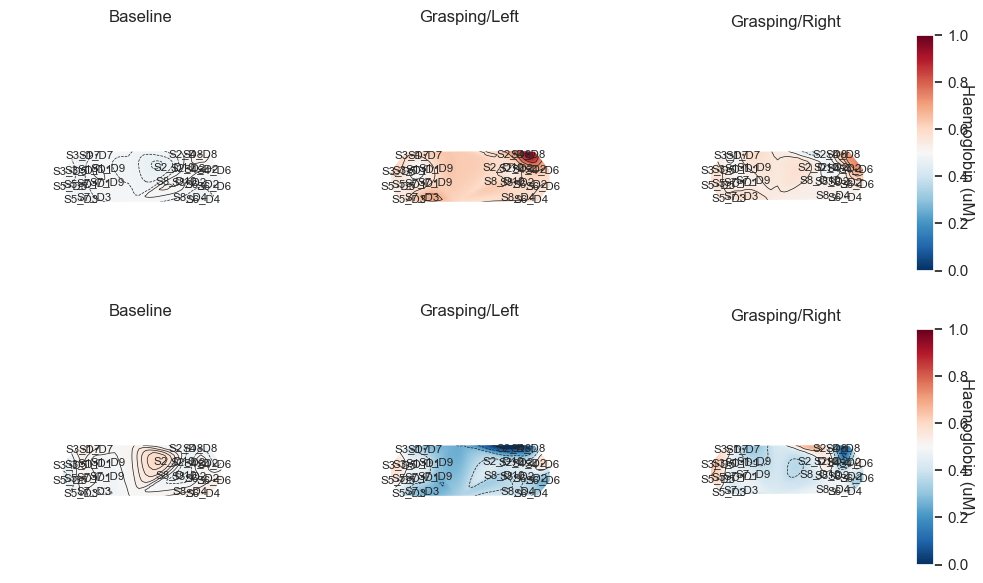

In [48]:
glm_est.plot_topo(conditions=['Baseline', 'Grasping/Left', 'Grasping/Right']);

---
> *Remark:*
-  Note that the control condition should sit around zero
-  HbO is positive and larger than the HbR
-  The response to tapping on the right hand is larger than the left hand, for the left hemisphere. And the opposite is true for the right hemisphere
---

##### Plot activity of both hemispheres seperate

Text(0.5, 1.0, 'Hemispheres plotted independently')

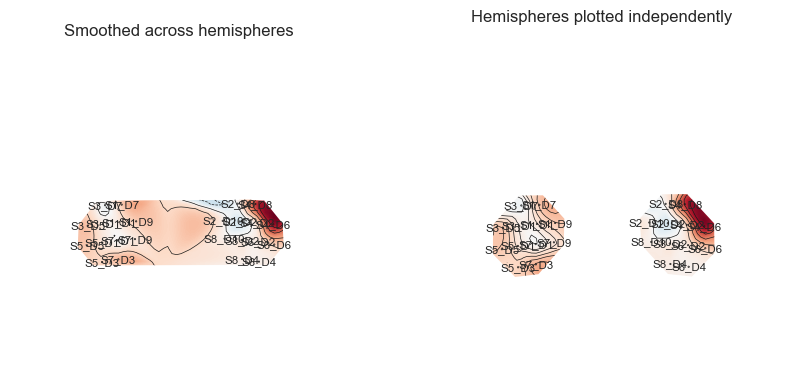

In [49]:
vlim = 0.3
if norm:
    vlim = vlim*1e6
# Right hand grasping (HbO)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1]))

glm_hbo = glm_est.copy().pick(picks="hbo")
conditions = ['Grasping/Right']

ROI_right = picks_pair_to_idx(raw_haemo.copy().pick('hbo'), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy().pick('hbo'), left, on_missing='warning')

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions, vlim = (-vlim,vlim))

glm_hbo.copy().pick(ROI_left).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim,vlim))
glm_hbo.copy().pick(ROI_right).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim,vlim))

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

Text(0.5, 1.0, 'Hemispheres plotted independently')

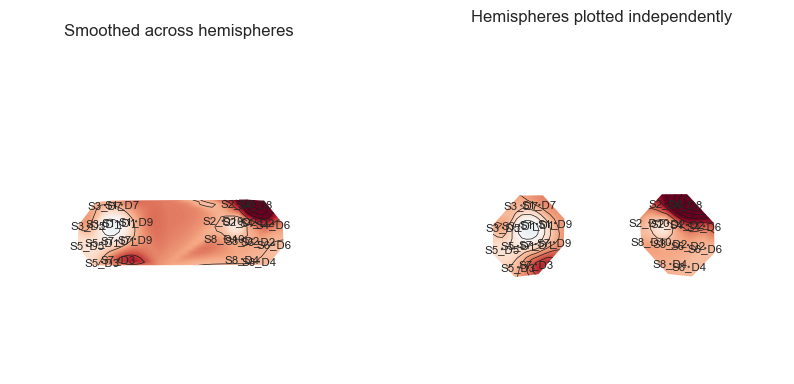

In [50]:
# Left hand grasping (HbO)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1]))

glm_hbo = glm_est.copy().pick(picks="hbo")
conditions = ['Grasping/Left']

ROI_right = picks_pair_to_idx(raw_haemo.copy().pick('hbo'), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy().pick('hbo'), left, on_missing='warning')

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions, vlim = (-vlim, vlim))

glm_hbo.copy().pick(ROI_left).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim, vlim))
glm_hbo.copy().pick(ROI_right).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim, vlim))

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

Text(0.5, 1.0, 'Hemispheres plotted independently')

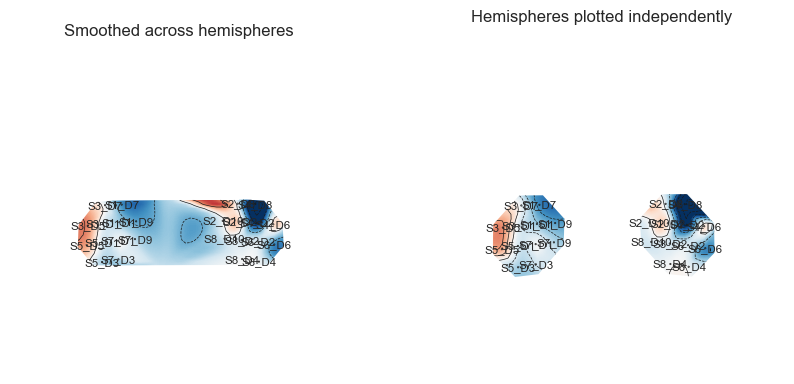

In [51]:
# Right hand grasping (HbR)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1]))

glm_hbo = glm_est.copy().pick(picks="hbr")
conditions = ['Grasping/Right']

ROI_right = picks_pair_to_idx(raw_haemo.copy().pick('hbr'), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy().pick('hbr'), left, on_missing='warning')

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions, vlim = (-vlim, vlim))

glm_hbo.copy().pick(ROI_left).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim, vlim))
glm_hbo.copy().pick(ROI_right).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim, vlim))

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

Text(0.5, 1.0, 'Hemispheres plotted independently')

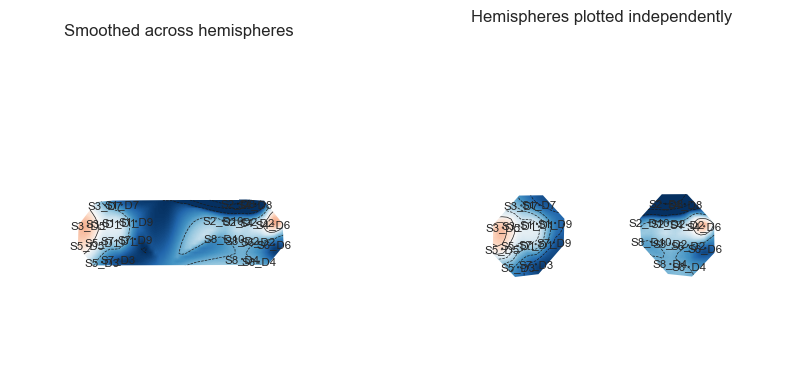

In [52]:
# Left hand grasping (HbR)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1]))

glm_hbo = glm_est.copy().pick(picks="hbr")
conditions = ['Grasping/Left']

ROI_right = picks_pair_to_idx(raw_haemo.copy().pick('hbr'), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy().pick('hbr'), left, on_missing='warning')

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions, vlim = (-vlim, vlim))

glm_hbo.copy().pick(ROI_left).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim, vlim))
glm_hbo.copy().pick(ROI_right).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vlim = (-vlim, vlim))

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

##### Project the GLM estimates to the nearest cortical surface

In [53]:
# # no photon migration! Not working and projection is on wrong place?
# sns.reset_orig
# glm_est.copy().surface_projection(condition="Grasping/Right", view="dorsal", chroma="hbo")

#### Analyse region of interest  <a class="anchor" id="sub_section_2_1_3"></a>

In [54]:
# Determine true and false positive rates
groups = dict(Left_ROI = ROI_left, Right_ROI = ROI_right)
conditions = ['Grasping/Left', 'Grasping/Right', 'Baseline']
df = glm_est.to_dataframe_region_of_interest(groups, conditions)
df["significant"] = df["p"] < 0.05
df.query('Condition in ["Baseline", "Grasping/Left", "Grasping/Right"]').groupby(['Condition', 'Chroma']).agg(['mean'])

C:\Users\fabia\AppData\Local\Temp\ipykernel_26692\138790345.py:6: FutureWarning: ['ROI', 'Weighted'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.query('Condition in ["Baseline", "Grasping/Left", "Grasping/Right"]').groupby(['Condition', 'Chroma']).agg(['mean'])


theta            se         t   dfe         p  \
                           mean          mean      mean  mean      mean   
Condition      Chroma                                                     
Baseline       hbo    -0.010265  20568.545020 -0.499085  36.0  0.620756   
               hbr     0.002503  30681.996729  0.081577  36.0  0.935435   
Grasping/Left  hbo     0.091126  24543.497387  3.712836  36.0  0.000691   
               hbr    -0.123080  36526.472497 -3.369601  36.0  0.001807   
Grasping/Right hbo     0.030131  24345.355974  1.237632  36.0  0.223864   
               hbr    -0.052365  36264.309707 -1.443969  36.0  0.157395   

                      significant  
                             mean  
Condition      Chroma              
Baseline       hbo            0.0  
               hbr            0.0  
Grasping/Left  hbo            1.0  
               hbr            1.0  
Grasping/Right hbo            0.0  
               hbr            0.0

SEE NIRX VIDEO: Significance can also be assessed per channel and then plot topograph of significant channels!

#### Compute contrast  <a class="anchor" id="sub_section_2_1_4"></a>

C:\Users\fabia\AppData\Roaming\Python\Python311\site-packages\nilearn\glm\contrasts.py:108: UserWarning: t contrasts should be of length P=36, but it has length 30. The rest of the contrast was padded with zeros.
  reg = regression_result[label_].Tcontrast(con_val)


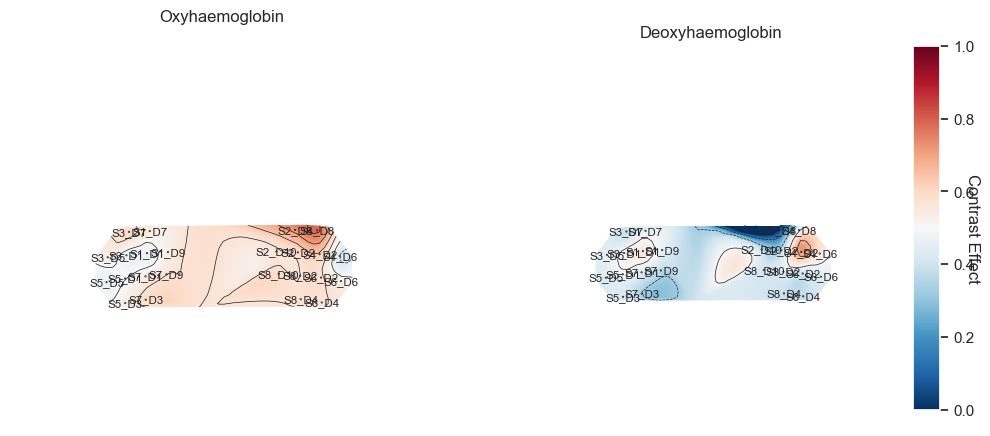

In [55]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_conts = dict([(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)])
contrast_LvR = basic_conts['Grasping/Left'] - basic_conts['Grasping/Right']

contrast = glm_est.compute_contrast(contrast_LvR)
contrast.plot_topo();

### Deconvolution (or FIR) model  <a class="anchor" id="section_2_2"></a>

#### Create design matrix <a class="anchor" id="sub_section_2_2_1"></a>

##### Select drift model

In [56]:
drift_model='cosine'
# Re-use high pass cut-off

##### Select HRF model

In [57]:
hrf_model = 'fir'

##### Choose number of delay steps

In [58]:
delay_steps = 10

In [59]:
print('Sample frequency: ' + str(raw_haemo.info['sfreq']) + ' Hz')
print('Delays: ' + str(raw_haemo.info['sfreq']*np.arange(0, 4*delay_steps, 4)))

Sample frequency: 5.154639175257731 Hz
Delays: [  0.          20.6185567   41.2371134   61.8556701   82.4742268
 103.09278351 123.71134021 144.32989691 164.94845361 185.56701031]


A FIR will be fit for each sample from the onset of a trigger. Specify that 10 FIR delays should be used. This results in values being estimated for 10 delay steps. Due to the sample rate of 5.15 Hz, these delays correspond to x1, x2, x3, … seconds from the onset of the stimulus.

##### Define design matrix

In [60]:
# Add additional regressors?
design_matrix_FIR = make_first_level_design_matrix(raw_haemo,
                                               drift_model = drift_model, # Options: ‘cosine’, ‘polynomial’
                                               # drift_order = 1, # Only for polynomial drift model
                                               high_pass = high_pass, # Only in case cosine drift model
                                               hrf_model = hrf_model, # Options: ‘glover’, ‘spm’, ‘spm + derivative’, ‘spm + derivative + dispersion’, ‘glover + derivative’, ‘glover + derivative + dispersion’, ‘fir’
                                               fir_delays = range(delay_steps), 
                                               stim_dur = raw_haemo.annotations.duration[0])

In [61]:
design_matrix_FIR.head(5)

,Baseline_delay_0,Baseline_delay_1,Baseline_delay_2,Baseline_delay_3,Baseline_delay_4,Baseline_delay_5,Baseline_delay_6,Baseline_delay_7,Baseline_delay_8,Baseline_delay_9,...,drift_18,drift_19,drift_20,drift_21,drift_22,drift_23,drift_24,drift_25,drift_26,constant
0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021334,0.021334,0.021334,0.021334,0.021334,0.021334,0.021334,0.021334,0.021334,1.0
0.194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021331,0.021330,0.021330,0.021329,0.021329,0.021328,0.021328,0.021327,0.021326,1.0
0.388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021324,0.021322,0.021321,0.021320,0.021318,0.021317,0.021315,0.021313,0.021312,1.0
0.582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021313,0.021311,0.021308,0.021305,0.021302,0.021299,0.021296,0.021293,0.021289,1.0
0.776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021299,0.021295,0.021290,0.021286,0.021281,0.021276,0.021271,0.021266,0.021260,1.0


##### Add SS as regressors

In [62]:
design_matrix_FIR_SS, _, _ = add_SS(raw_haemo_short, design_matrix_FIR, method = 'mean', n_components = 0.95)
design_matrix_SS.head(5)

,Baseline,Grasping/Left,Grasping/Right,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,...,drift_20,drift_21,drift_22,drift_23,drift_24,drift_25,drift_26,constant,ShortHbO,ShortHbR
0.000,0.0,0.0,0.0,0.021335,0.021335,0.021335,0.021335,0.021335,0.021335,0.021335,...,0.021334,0.021334,0.021334,0.021334,0.021334,0.021334,0.021334,1.0,0.660179,1.669197
0.194,0.0,0.0,0.0,0.021335,0.021335,0.021335,0.021334,0.021334,0.021334,0.021334,...,0.021330,0.021329,0.021329,0.021328,0.021328,0.021327,0.021326,1.0,0.219879,1.358870
0.388,0.0,0.0,0.0,0.021335,0.021334,0.021334,0.021334,0.021334,0.021333,0.021333,...,0.021321,0.021320,0.021318,0.021317,0.021315,0.021313,0.021312,1.0,1.092408,1.912163
0.582,0.0,0.0,0.0,0.021335,0.021334,0.021334,0.021334,0.021333,0.021332,0.021331,...,0.021308,0.021305,0.021302,0.021299,0.021296,0.021293,0.021289,1.0,1.054240,1.789870
0.776,0.0,0.0,0.0,0.021335,0.021334,0.021334,0.021333,0.021332,0.021331,0.021329,...,0.021290,0.021286,0.021281,0.021276,0.021271,0.021266,0.021260,1.0,0.728880,1.745476


##### Add IMU data as regressors

In [63]:
design_matrix_FIR_SS_IMU, _, _ = add_IMU(design_matrix_FIR_SS, IMU_data, method = 'PCA', n_components = 0.95)

mean: [ True  True  True  True  True  True]
std: [1. 1. 1. 1. 1. 1.]
4 IMU channels are kept of the original 6


In [64]:
design_matrix_FIR_SS_IMU.head(5)

,Baseline_delay_0,Baseline_delay_1,Baseline_delay_2,Baseline_delay_3,Baseline_delay_4,Baseline_delay_5,Baseline_delay_6,Baseline_delay_7,Baseline_delay_8,Baseline_delay_9,...,drift_24,drift_25,drift_26,constant,ShortHbO,ShortHbR,IMU_PCA_0,IMU_PCA_1,IMU_PCA_2,IMU_PCA_3
0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021334,0.021334,0.021334,1.0,0.660179,1.669197,1.177441,2.608803,-0.862812,-0.332572
0.194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021328,0.021327,0.021326,1.0,0.219879,1.358870,1.606900,2.770771,-0.549541,-0.209625
0.388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021315,0.021313,0.021312,1.0,1.092408,1.912163,1.376215,2.641867,-1.026111,-0.270150
0.582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021296,0.021293,0.021289,1.0,1.054240,1.789870,1.225062,2.629626,-0.819520,-0.040384
0.776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021271,0.021266,0.021260,1.0,0.728880,1.745476,1.490913,2.195481,-1.076847,-0.208658


##### Display a summary of the design matrix 

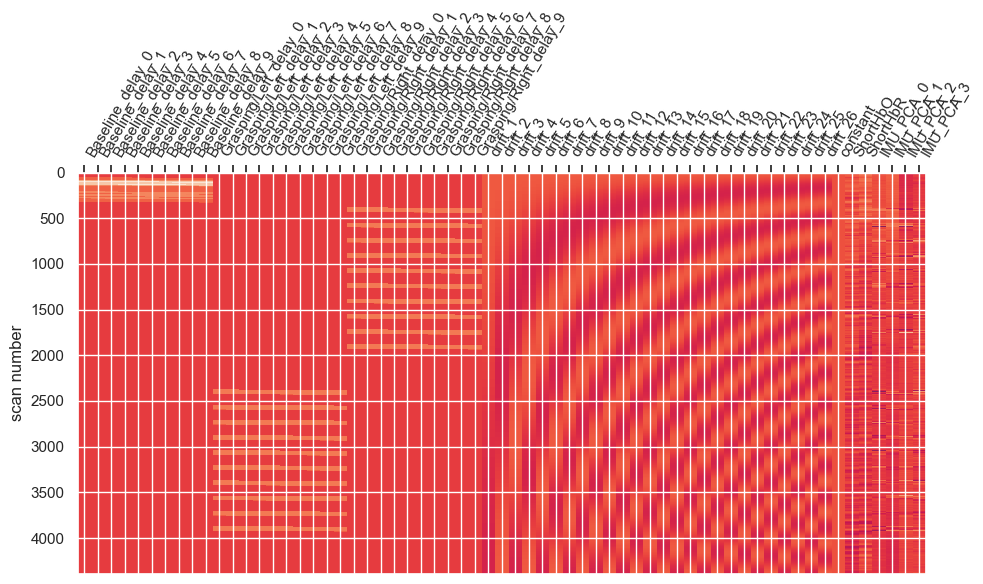

In [65]:
fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix_FIR_SS_IMU, ax=ax1)

##### Examine expected response

Used Annotations descriptions: ['Baseline', 'Grasping/Left', 'Grasping/Right']


[(0.0, 800.0), Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Amplitude')]

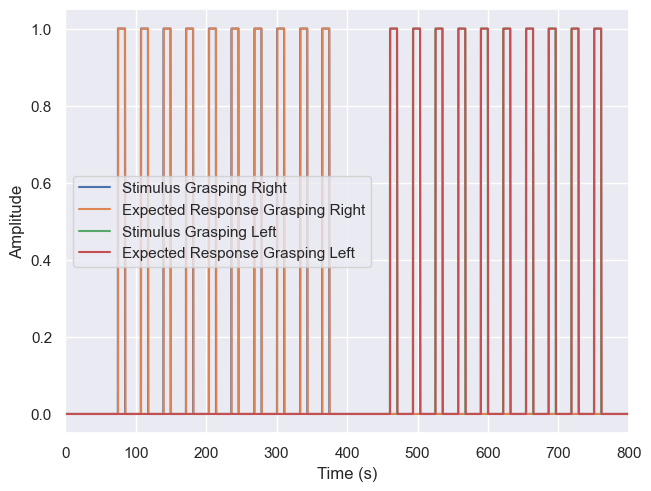

In [66]:
# Does not work
fig, ax = plt.subplots(constrained_layout=True)
s = mne_nirs.experimental_design.create_boxcar(raw_haemo, stim_dur=raw_haemo.annotations.duration[0])
ax.plot(raw_intensity.times, s[:, 2])
ax.plot(design_matrix_FIR_SS_IMU['Grasping/Right_delay_2'])
ax.plot(raw_intensity.times, s[:, 1])
ax.plot(design_matrix_FIR_SS_IMU['Grasping/Left_delay_2'])
ax.legend(["Stimulus Grasping Right", "Expected Response Grasping Right", "Stimulus Grasping Left", "Expected Response Grasping Left"])
ax.set(xlim=(0, 800), xlabel="Time (s)", ylabel="Amplitude")

#### Fit GLM to data <a class="anchor" id="sub_section_2_2_2"></a>

##### Run a GLM fit for the data and experiment matrix

In [67]:
glm_est_FIR = run_glm(raw_haemo, design_matrix_FIR_SS_IMU, noise_model='ar4') # {‘ar1’, ‘ols’, ‘arN’, ‘auto’}
glm_est_FIR

GLM Results for 48 channels

##### Display results of GLM in scatter plot

In [68]:
ROI_right = picks_pair_to_idx(raw_haemo.copy(), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy(), left, on_missing='warning')

<AxesSubplot: xlabel='Condition', ylabel='Theta'>

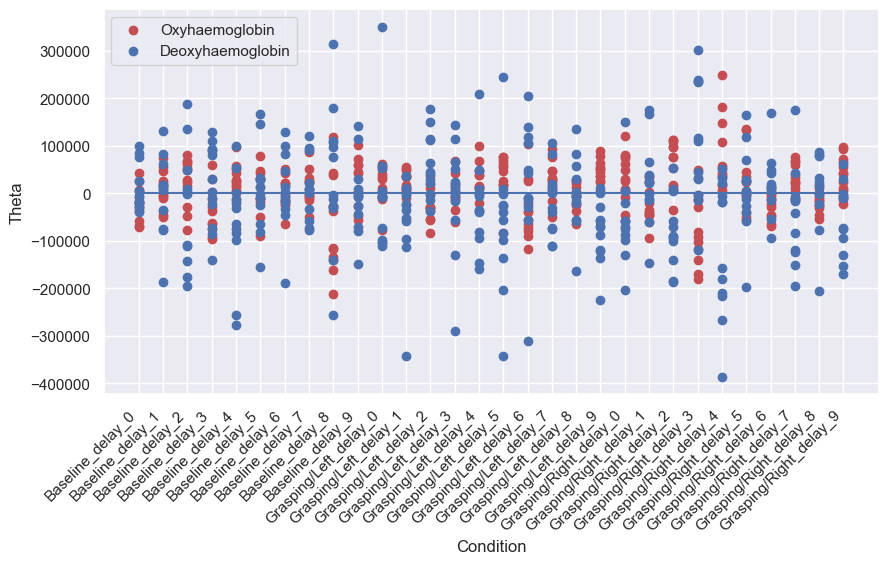

In [69]:
cond = ['Baseline_delay_' + str(i)  for i in range(10)] + ['Grasping/Left_delay_' + str(i)  for i in range(10)]  + ['Grasping/Right_delay_' + str(i)  for i in range(10)]

# Left hemisphere
glm_est_FIR.copy().pick(picks = ROI_left).scatter(conditions = cond)

<AxesSubplot: xlabel='Condition', ylabel='Theta'>

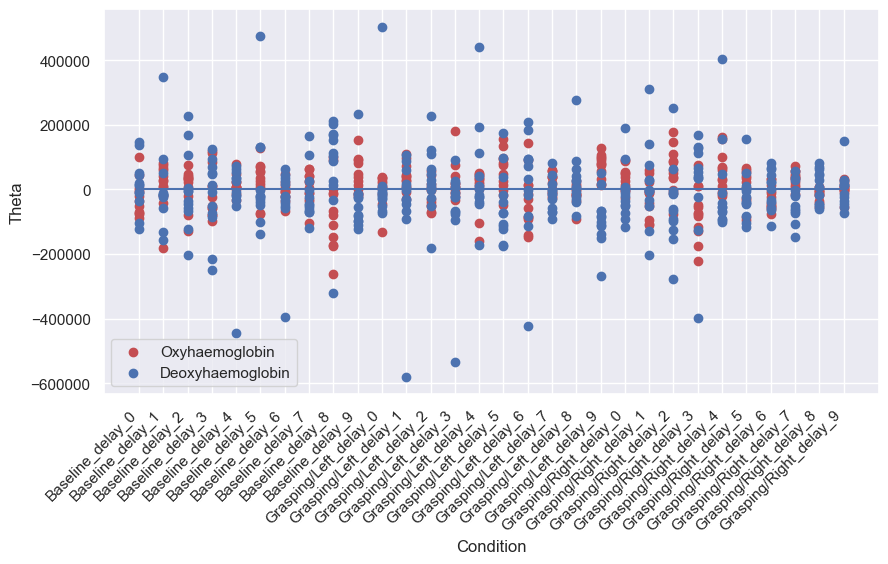

In [70]:
# Left hemisphere
glm_est_FIR.copy().pick(picks = ROI_right).scatter(conditions = cond)

#### Analyse region of interest  <a class="anchor" id="sub_section_2_2_3"></a>

In [71]:
# Create a ROI for left and right hemisphere
ROI_right = picks_pair_to_idx(raw_haemo.copy().pick('hbo'), right, on_missing='warning')
ROI_left = picks_pair_to_idx(raw_haemo.copy().pick('hbo'), left, on_missing='warning')
groups = dict(Left_ROI = ROI_left, Right_ROI = ROI_right)
# Calculate ROI for all conditions
conditions = design_matrix_FIR_SS_IMU.columns
# Compute output metrics by ROI
df_FIR = glm_est_FIR.to_dataframe_region_of_interest(groups, conditions)
df_FIR["theta"] = [t * 1.e6 for t in df_FIR["theta"]] # Correct unit
df_FIR["significant"] = df_FIR["p"] < 0.05

In [72]:
df_FIR['Condition'].to_list()

['Baseline_delay_0',
 'Baseline_delay_0',
 'Baseline_delay_1',
 'Baseline_delay_1',
 'Baseline_delay_2',
 'Baseline_delay_2',
 'Baseline_delay_3',
 'Baseline_delay_3',
 'Baseline_delay_4',
 'Baseline_delay_4',
 'Baseline_delay_5',
 'Baseline_delay_5',
 'Baseline_delay_6',
 'Baseline_delay_6',
 'Baseline_delay_7',
 'Baseline_delay_7',
 'Baseline_delay_8',
 'Baseline_delay_8',
 'Baseline_delay_9',
 'Baseline_delay_9',
 'Grasping/Left_delay_0',
 'Grasping/Left_delay_0',
 'Grasping/Left_delay_1',
 'Grasping/Left_delay_1',
 'Grasping/Left_delay_2',
 'Grasping/Left_delay_2',
 'Grasping/Left_delay_3',
 'Grasping/Left_delay_3',
 'Grasping/Left_delay_4',
 'Grasping/Left_delay_4',
 'Grasping/Left_delay_5',
 'Grasping/Left_delay_5',
 'Grasping/Left_delay_6',
 'Grasping/Left_delay_6',
 'Grasping/Left_delay_7',
 'Grasping/Left_delay_7',
 'Grasping/Left_delay_8',
 'Grasping/Left_delay_8',
 'Grasping/Left_delay_9',
 'Grasping/Left_delay_9',
 'Grasping/Right_delay_0',
 'Grasping/Right_delay_0',
 'Gras

In [73]:
df_FIR.groupby(['Condition', 'Chroma']).agg(['mean'])

C:\Users\fabia\AppData\Local\Temp\ipykernel_26692\1386236111.py:1: FutureWarning: ['ROI', 'Weighted'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_FIR.groupby(['Condition', 'Chroma']).agg(['mean'])


theta             se         t   dfe  \
                                 mean           mean      mean  mean   
Condition        Chroma                                                
Baseline_delay_0 hbo    -5.501910e+04   46639.341029 -1.179672  63.0   
                 hbr     3.383366e+04   62643.851199  0.540096  63.0   
Baseline_delay_1 hbo     4.351955e+04   68773.616678  0.632794  63.0   
                 hbr    -2.063397e+04   90524.931544 -0.227937  63.0   
Baseline_delay_2 hbo     4.704553e+04   68937.377720  0.682439  63.0   
...                               ...            ...       ...   ...   
drift_7          hbr    -1.867296e+06  755128.700490 -2.472819  63.0   
drift_8          hbo     1.313859e+05  492932.851454  0.266539  63.0   
                 hbr     1.963127e+06  748889.671566  2.621384  63.0   
drift_9          hbo    -2.153654e+05  489472.948904 -0.439994  63.0   
                 hbr    -1.912432e+05  743414.458188 -0.257250  63.0   

                                p significant  
                             mean        mean  
Condition        Chroma                        
Baseline_delay_0 hbo     0.242566         0.0  
                 hbr     0.591035         0.0  
Baseline_delay_1 hbo     0.529158         0.0  
                 hbr     0.820433         0.0  
Baseline_delay_2 hbo     0.497463         0.0  
...                           ...         ...  
drift_7          hbr     0.016116         1.0  
drift_8          hbo     0.790694         0.0  
                 hbr     0.010965         1.0  
drift_9          hbo     0.661447         0.0  
                 hbr     0.797824         0.0  

[126 rows x 6 columns]

### Implement AR-IRLS
Based on Barker et al. (2013) and the AR-IRLS function of NIRS toolbox (Santosa et al. (2018))

In [174]:
# Help functions
def myFilter(f, y):
    # Make the first value zero before filtering to avoid weird effects introduced by zero padding
    y1 = y[0]
    y = y - y1
    # Lowpass-filter
    out = lfilter(f, 1, y, axis=0)
    # Add the corrected offset back
    out = out + np.sum(f) * y1
    return out

def lagmatrix(y, lags):
    n = len(y)
    N = max(lags)

    # Create the Hankel matrix equivalent to convmtx in MATLAB
    y_padded = np.pad(y, (N, 0), 'constant', constant_values=(0, 0))
    y_hankel = hankel(y_padded[:-N], y_padded[-N:])
    id = np.arange(N)
    ylag = y_hankel[:n, id]
    
    return ylag

def infocrit(LogL, num_obs, num_param, criterion='BIC'):
    """
    Calculate information criterion from Log-Likelihood (BIC, AIC, AICc, CAIC)
    Parameters:
        LogL (float or np.ndarray): Log-likelihood values
        num_obs (int): Number of observations
        num_param (int or np.ndarray): Number of parameters
        criterion (str): Criterion to use ('BIC', 'AIC', 'AICc', 'CAIC')
    Returns:
        crit (float or np.ndarray): Calculated information criterion
    """
    if criterion.upper() == 'BIC':
        crit = -2 * LogL + num_param * np.log(num_obs)
    elif criterion.upper() == 'AIC':
        crit = -2 * LogL + 2 * num_param
    elif criterion.upper() == 'AICC':
        crit = -2 * LogL + 2 * num_param + 2 * num_param * (num_param + 1) / (num_obs - num_param - 1)
        crit[(num_obs - num_param - 1) <= 0] = np.nan
    elif criterion.upper() == 'CAIC':
        crit = -2 * LogL + num_param * (1 + np.log(num_obs))
    else:
        raise ValueError(f"Unknown model selection criterion: {criterion}")
    
    return crit

def stepwise(X, y, criterion='BIC'):
    # QR factorization
    Q, R = np.linalg.qr(X)
    invR = np.linalg.pinv(R)
    
    n = y.shape[0]
    LL = np.full(X.shape[1], np.nan)
    
    for i in range(len(LL)):
        # Get residual for each fit
        b = invR[:i+1, :i+1] @ Q[:, :i+1].T @ y
        r = y - X[:, :i+1] @ b
        
        # Calculate log-likelihood
        LL[i] = -n / 2 * np.log(2 * np.pi * np.mean(r**2)) - n / 2
        
    # Calculate information criterion
    k = np.arange(1, len(LL) + 1)
    crit = infocrit(LL, n, k, criterion)
    
    # Optimal model order
    N = np.argmin(crit)
    
    # Output
    b = invR[:N+1, :N+1] @ Q[:, :N+1].T @ y
    r = y - X[:, :N+1] @ b
    
    return b, r, crit


def ar_fit(y, Pmax):
    """
    Fit an AR model to the time series y with maximum order Pmax.
    """
    n = len(y)
    
    Xf = lagmatrix(y, range(1, Pmax+1))
    Xb = lagmatrix(y[::-1], range(1, Pmax+1))
    
    X = np.hstack([np.ones((2 * n, 1)), np.vstack([Xf, Xb])])
    yy = np.hstack([y, y[::-1]])
    
    coef, res, _ = stepwise(X, yy)
    
    res = res[:n]
    yhat = y - res
    
    return coef, res, yhat

In [179]:
def ar_irls(raw_haemo, design_matrix, Pmax = None, tune=4.685):
    # Put Pmax around 4-5 times sample freq
    # X is the regression/design matrix
    # "tune" is the tuning constant used for Tukey's bisquare function during IRLS: default tune value = 95% statistical efficiency
    
    d = raw_haemo.copy().get_data().T
    X = design_matrix.to_numpy()
    
    if Pmax == None:
        Pmax = round(4*raw_haemo.info['sfreq']) # Recommended by Santosa
        print('Pmax = ' + str(Pmax))
    
    nCond = X.shape[1]
    nChan = d.shape[1]
    nTime = d.shape[0]
    
    stats = {
        'beta': np.zeros((nCond, nChan)),
        'tstat': np.zeros((nCond, nChan)),
        'pval': np.zeros((nCond, nChan)), # Two sided t-test
        'ppos': np.zeros((nCond, nChan)), # One-sided positive
        'pneg': np.zeros((nCond, nChan)), # One-sided negative
        'P': np.zeros(nChan), # The final AR model order
        'w': np.zeros((nTime, nChan)), # Save the weights
        'dof': nTime - nCond # dof
    }
    
    resid = np.zeros((nTime, nChan))

    # Loop through each channel
    for i in range(nChan):
        y = d[:, i]

        B = np.linalg.pinv(X) @ y  # X^+ = (X^T.X)^(-1).X^T
        B0 = 1e6 * np.ones_like(B)

        # IRLS
        iter = 0
        maxiter = 10
        
        while np.linalg.norm(B - B0) / np.linalg.norm(B0) > 1e-2 and iter < maxiter:
            B0 = B
            res = y - X @ B
            
            a = ar_fit(res, Pmax)
            f = np.concatenate(([1], -1*a[1:]))
            
            Xf = myFilter(f, X)
            yf = myFilter(f, y)

            M = M=TukeyBiweight(tune)
            model = RLM(yf, Xf, M=M)
            results = model.fit()
            B = results.params
            S = results.scale
            
            iter += 1
        
        wXf = Xf * results.weights[:, None]
        U, _, _ = np.linalg.svd(wXf)
        stats['dfe'] = np.sum(results.weights) - np.sum(U**2)
        
        H = np.diag(results.weights) - wXf @ np.linalg.pinv(wXf.T @ wXf) @ wXf.T
        HtH = H.T @ H
        
        stats['dfe'] = np.sum(H**2)**2 / np.sum(HtH**2)
        
        stats['beta'][:, i] = B
        stats['P'][i] = len(a) - 1
        L = np.linalg.pinv(Xf.T @ Xf)
        stats['w'][:, i] = results.weights
        stats['tstat'][:, i] = stats['beta'][:, i] / np.sqrt(np.diag(results.normalized_cov_params))
        stats['pval'][:, i] = 2 * t.cdf(-np.abs(stats['tstat'][:, i]), stats['dfe'])
        stats['ppos'][:, i] = t.cdf(-stats['tstat'][:, i], stats['dfe'])
        stats['pneg'][:, i] = t.cdf(stats['tstat'][:, i], stats['dfe'])
        resid[:, i] = results.resid * results.weights
    
    resid -= np.nanmedian(resid, axis=0)
    
    return stats, resid

In [180]:
stats, resid = ar_irls(raw_haemo, design_matrix, Pmax = None, tune=4.685)

Pmax = 21


In [184]:
stats

{'beta': array([[ 3.03251234e-02, -6.08454177e-02,  2.86664039e-02, ...,
         -7.92905055e-02,  5.37818345e-02, -8.86373106e-02],
        [-1.02273045e-01,  1.01350462e-01, -3.16395978e-02, ...,
          1.74995619e-02, -8.87808264e-02,  8.37291380e-02],
        [ 7.88825915e-02, -1.85426346e-01, -1.60090766e-02, ...,
         -1.36790544e-01,  2.99653866e-02, -7.67546962e-02],
        ...,
        [-8.05871797e-01,  1.08329863e+00, -1.52085454e-01, ...,
         -5.35439025e-01,  1.32205137e-01, -5.75023849e-01],
        [-2.06019100e+00,  3.55798211e+00, -2.66535767e+00, ...,
          4.30868250e+00, -2.27862815e+00,  3.32105484e+00],
        [-3.57129488e-03,  1.90260269e-02, -1.28527110e-02, ...,
          1.93429747e-02, -4.43034678e-03,  1.23271984e-02]]),
 'tstat': array([[ 0.67494007, -1.35422402,  0.63802229, ..., -1.76475257,
          1.19701129, -1.9727825 ],
        [-1.91004015,  1.89281011, -0.59089766, ...,  0.3268199 ,
         -1.65806097,  1.56371619],
        

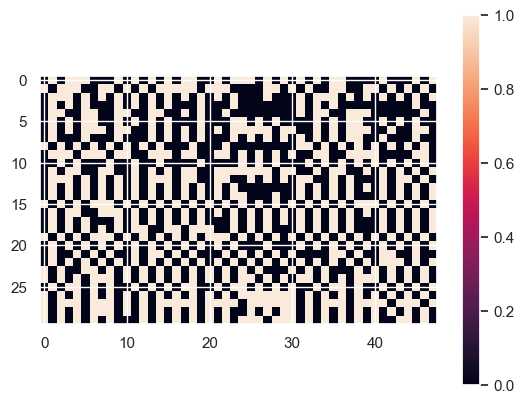

In [190]:
plt.imshow(np.where(stats['tstat'] < 0.05, 1, 0))
plt.colorbar()